In [1]:
# dataset
from torchvision import datasets

from functools import partial
import numpy as np
from copy import deepcopy

# visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# preprocessing
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split

# model
import torch
from torch import nn
import torchvision.models as models
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

# hyperparameter tuning
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

# metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# 1. Load Data & Preprocessing

**Dataset**: <a href="https://www.cs.toronto.edu/~kriz/cifar.html" target="_blank">CIFAR-10</a>

**Classes**: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

The following transformations are used:
* **resize**
* **center crop**
* **normalization**: from [0, 255] to [0, 1]
* **standardization**: by substracting the mean and dividing with std according to ImageNet

In [2]:
def load_data(data_dir):
    """ Create train and test pytorch dataset objects from CIFAR-10.
    
    The following tranformations are applied on CIFAR-10:
        * resize images,
        * center crop images,
        * normalization: from [0, 255] to [0, 1] by dividing with 255,
        * standardization: by substracting the mean and dividing with std according to ImageNet
    
    Args:
        data_dir:
            directory where data will be saved, as a string.
    
    Returns:
        train and test dataset, as pytorch dataset objects.
    """
    transform = transforms.Compose([
        transforms.Resize(224), 
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    trainset = datasets.CIFAR10(root=data_dir,
                                train=True, 
                                download=True, 
                                transform=transform)

    testset = datasets.CIFAR10(root=data_dir, 
                               train=False, 
                               download=True, 
                               transform=transform)

    return trainset, testset

In [3]:
trainset, testset = load_data(data_dir='cifar10')

print(f'\nTraining data:\n--------------\n{trainset}')
print(f'Test data:\n--------------\n{testset}')

Files already downloaded and verified
Files already downloaded and verified

Training data:
--------------
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: cifar10-pytorch
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Test data:
--------------
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: cifar10-pytorch
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [4]:
batch_size = 64

train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

# 2. AlexNet

We'll use the **pretrained version** of AlexNet. Since CIFAR-10 dataset has less classes than ImageNet, we'll keep all the layers **freezed**, except of the last one, which will be **unfreezed** and updated with the right number of classes and will be re-trained.

<img src="images/alexnet.png" alt="AlexNet">

Regularization:
* Weight decay (L2 regularization)

Loss Function:
* Cross Entropy Loss

Optimizer and Scheduler:
* Adam optimizer
* ReduceLROnPlateau scheduler

In [5]:
def set_parameter_requires_grad(model, feature_extracting):
    """ This helper function sets the .requires_grad attribute of the parameters in the model 
    to False when we are feature extracting. 
    
    When we are feature extracting and only want to compute gradients for the newly initialized layer, 
    then we want all of the other parameters to not require gradients.
    
    Args:
        model: 
            deep learning model, as pytorch object.
        feature_extracting:
            whether or not we're feature extracting, as boolean.
    """
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [6]:
def initialize_model(num_labels, feature_extracting, pretrained=True):
    """ Initialize AlexNet model and reshape the last layer with the correct number of classes.
    
    Since AlexNet has been pretrained on Imagenet, it has output layers of size 1000, one node for each class. 
    We reshape the last layer to have the same number of inputs as before, and to have the same number of 
    outputs as the number of classes in our the dataset.
    
    Args:
        num_labels:
            number of labels in our dataset, as integer.
        feature_extracting:
          flag for feature extracting (when False, we finetune the whole model, 
          when True we only update the reshaped layer params), as boolean.
        pretrained:
            whether or not we want the pretrained version of AlexNet, as boolean.
    
    Returns:
        AlexNet model, as pytorch object
    """
    model = models.alexnet(pretrained=pretrained)
    
    set_parameter_requires_grad(model, feature_extracting)
    
    last_layer_in_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(last_layer_in_ftrs, num_labels)
    
    return model

# 3. Hyperparameter Tuning

We'll use **early stopping** with **ASHAScheduler** to stop bad trials earlier.

|                               | Validation Loss | Validation Accuracy |
| :---------------------------: | :-------------: | :-----------------: |
| AlexNet                       | 0.44            | 84%                 |

Best trial **configuration** for AlexNet: lr: 0.0001, l2: 0.001

In [7]:
def tune_helper(config, trainset, num_labels, batch_size, epochs):
    """ Fit deep learning model and test it on a hold-out validation set.
    
    The validation set is a 20% hold-out set of the training set. 
    The loss function used is Cross Entropy Loss.
    The optimer used is Adam and the scheduler that wraps the optimizer is ReduceLROnPlateau.
    The metric used is accuracy score.
    
    Args:
        config:
            hyperparameters of neural network, as a dictionary.
        trainset:
            training dataset, as a pytorch object.
        num_labels:
            number of labels, as an integer.
        batch_size:
            size of batches to be processed, as an integer.
        epochs:
            number of epochs (times the neural network will see the data), as an integer.
    """
    feature_extracting = True
    pretrained = True
    model = initialize_model(num_labels=num_labels, 
                             feature_extracting=feature_extracting, 
                             pretrained=pretrained)
    
    # support data parallel training on multiple GPUs
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)
    
    # create an optimizer that only updates the desired parameters
    params_to_update = model.parameters()
    print("Parameters to learn:")
    if feature_extracting:
        params_to_update = []
        for name, param in model.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t", name)
    else:
        for name, param in model.named_parameters():
            if param.requires_grad == True:
                print("\t", name)
    
    # optimizer
    optimizer = AdamW(params_to_update, lr=config['lr'], weight_decay=config['l2'])
    
    #scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min')
    
    
    # loss function
    loss_fn = nn.CrossEntropyLoss()
    
    # split data: training (80%) - validation (20%)
    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(trainset, [test_abs, len(trainset) - test_abs])

    train_dataloader = DataLoader(train_subset,
                                  batch_size=batch_size,
                                  shuffle=True, 
                                  num_workers=2)
    
    val_dataloader = DataLoader(val_subset,
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=2)
    
    for epoch in range(epochs):
        # fit neural network on training data
        model.train()  # put on train mode
        for batch, (X, Y) in enumerate(train_dataloader, 0):
            # send the data to the GPU memory explicitly
            X, Y = X.to(device), Y.to(device)

            # reset the gradients
            optimizer.zero_grad()
            
            # compute prediction
            pred = model(X)

            # compute loss
            loss = loss_fn(pred, Y)

            # backpropagate
            loss.backward()

            # update parameters
            optimizer.step()
        
        # test on validation data
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        model.eval()  # put on evaluation mode
        for batch, (X, Y) in enumerate(val_dataloader, 0):
            with torch.no_grad():
                X, Y = X.to(device), Y.to(device)

                pred = model(X)
                
                _, predicted = torch.max(pred.data, 1)
                total += Y.size(0)
                correct += (predicted == Y).sum().item()

                loss = loss_fn(pred, Y)
                val_loss += loss.cpu().numpy()
                val_steps += 1
        
        # update scheduler
        scheduler.step(val_loss)
        
        # report metrics
        tune.report(loss=(val_loss / val_steps), accuracy=(correct / total))

In [8]:
def hyperparameter_tune(data_dir,
                        batch_size,
                        epochs,
                        config,
                        grace_period,
                        num_samples, 
                        cpus_per_trial,
                        gpus_per_trial):
    """ Run hyperparameter tuning and report best hyperparameters.
    
    Args:
        data_dir:
            directory where CIFAR-10 data will be saved/loaded, as a string.
        batch_size:
            size of batches to be processed, as an integer.
        epochs:
            number of epochs (times the neural network will see the data), as an integer.
        config:
            hyperparametes, as a dictionary.
        grace_period:
            stop trials at least this old in time, as an integer.
        num_samples:
            number of times to sample from the hyperparameter space (if grid_search is provided as an argument,
            the grid will be repeated num_samples of times), as an integer.
        cpus_per_trial:
            CPUs to allocate per trial, as integer.
        gpus_per_trial:
            GPUs to allocate per trial, as integer.
    """
    trainset, testset = load_data(data_dir=data_dir)
    
    num_labels = 10
    
    # hyperparameter search space
    cofig = config
    
    # used for early stopping
    scheduler = ASHAScheduler(metric="loss", 
                              mode="min",
                              max_t=epochs,
                              grace_period=grace_period,
                              reduction_factor=2)
    
    reporter = CLIReporter(metric_columns=["loss", "accuracy", "training_iteration"])
    
    # hyperparamet tuning
    result = tune.run(tune.with_parameters(tune_helper,
                                           trainset=trainset,
                                           num_labels=num_labels,
                                           batch_size=batch_size,
                                           epochs=epochs),
                      resources_per_trial={"cpu": cpus_per_trial, "gpu": gpus_per_trial},
                      config=config,
                      num_samples=num_samples,
                      scheduler=scheduler,
                      progress_reporter=reporter)
    
    # report best results
    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(best_trial.last_result["loss"]))
    print("Best trial final validation acurracy: {}".format(best_trial.last_result["accuracy"]))

In [9]:
# hyperparameter search space
config = {
    "lr": tune.grid_search([1e-3, 1e-4]),
    "l2": tune.grid_search([1e-3, 1e-4])
    }

In [10]:
hyperparameter_tune(data_dir='cifar10-pytorch',
                    batch_size=64,
                    epochs=100,
                    config=config,
                    grace_period=30,
                    num_samples=1, 
                    cpus_per_trial=0,
                    gpus_per_trial=1)

Files already downloaded and verified
Files already downloaded and verified


2021-09-03 13:30:55,416	INFO services.py:1247 -- View the Ray dashboard at http://127.0.0.1:8265
2021-09-03 13:31:08,438	WARNING function_runner.py:545 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
2021-09-03 13:31:09,284	ERROR syncer.py:72 -- Log sync requires rsync to be installed.


== Status ==
Memory usage on this node: 5.5/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: None
Resources requested: 0/8 CPUs, 0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (4 PENDING)
+-------------------------+----------+-------+--------+--------+
| Trial name              | status   | loc   |     l2 |     lr |
|-------------------------+----------+-------+--------+--------|
| tune_helper_0d08a_00000 | PENDING  |       | 0.001  | 0.001  |
| tune_helper_0d08a_00001 | PENDING  |       | 0.0001 | 0.001  |
| tune_helper_0d08a_00002 | PENDING  |       | 0.001  | 0.0001 |
| tune_helper_0d08a_00003 | PENDING  |       | 0.0001 | 0.0001 |
+-------------------------+----------+-------+--------+--------+


== Status ==
Memory usage on this node: 5.9/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: None
Resources requested

(pid=13300) C:\Users\lampr\anaconda3\envs\cbir-dl\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
(pid=13300)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for tune_helper_0d08a_00000:
  accuracy: 0.8004
  date: 2021-09-03_13-33-21
  done: false
  experiment_id: 76a21f43a91d4fe89fae90036d69c6a5
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 1
  loss: 0.5697763920969264
  node_ip: 192.168.1.20
  pid: 13300
  time_since_restore: 130.47888469696045
  time_this_iter_s: 130.47888469696045
  time_total_s: 130.47888469696045
  timestamp: 1630665201
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0d08a_00000
  
== Status ==
Memory usage on this node: 6.6/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: None
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+--------------------+--------+

Result for tune_helper_0d08a_00000:
  accuracy: 0.8204
  date: 2021-09-03_13-40-04
  done: false
  experiment_id: 76a21f43a91d4fe89fae90036d69c6a5
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 6
  loss: 0.5362322609515706
  node_ip: 192.168.1.20
  pid: 13300
  time_since_restore: 533.5429983139038
  time_this_iter_s: 78.52236461639404
  time_total_s: 533.5429983139038
  timestamp: 1630665604
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0d08a_00000
  
== Status ==
Memory usage on this node: 5.4/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: None
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+--------------------+--------+---

Result for tune_helper_0d08a_00000:
  accuracy: 0.8201
  date: 2021-09-03_13-46-35
  done: false
  experiment_id: 76a21f43a91d4fe89fae90036d69c6a5
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 11
  loss: 0.5285934433341026
  node_ip: 192.168.1.20
  pid: 13300
  time_since_restore: 924.3302848339081
  time_this_iter_s: 77.69220662117004
  time_total_s: 924.3302848339081
  timestamp: 1630665995
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 0d08a_00000
  
== Status ==
Memory usage on this node: 5.2/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: None
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+--------------------+--------+-

Result for tune_helper_0d08a_00000:
  accuracy: 0.8155
  date: 2021-09-03_13-53-04
  done: false
  experiment_id: 76a21f43a91d4fe89fae90036d69c6a5
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 16
  loss: 0.5623732382894322
  node_ip: 192.168.1.20
  pid: 13300
  time_since_restore: 1313.3987956047058
  time_this_iter_s: 78.050368309021
  time_total_s: 1313.3987956047058
  timestamp: 1630666384
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 0d08a_00000
  
== Status ==
Memory usage on this node: 5.4/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: None
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+--------------------+--------+-

Result for tune_helper_0d08a_00000:
  accuracy: 0.8231
  date: 2021-09-03_13-59-30
  done: false
  experiment_id: 76a21f43a91d4fe89fae90036d69c6a5
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 21
  loss: 0.5551563046730248
  node_ip: 192.168.1.20
  pid: 13300
  time_since_restore: 1699.6914184093475
  time_this_iter_s: 76.45868301391602
  time_total_s: 1699.6914184093475
  timestamp: 1630666770
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: 0d08a_00000
  
== Status ==
Memory usage on this node: 5.3/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: None
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+--------------------+--------

Result for tune_helper_0d08a_00000:
  accuracy: 0.8316
  date: 2021-09-03_14-06-00
  done: false
  experiment_id: 76a21f43a91d4fe89fae90036d69c6a5
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 26
  loss: 0.4997407849047594
  node_ip: 192.168.1.20
  pid: 13300
  time_since_restore: 2089.4839837551117
  time_this_iter_s: 78.9330735206604
  time_total_s: 2089.4839837551117
  timestamp: 1630667160
  timesteps_since_restore: 0
  training_iteration: 26
  trial_id: 0d08a_00000
  
== Status ==
Memory usage on this node: 5.4/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: None
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+--------------------+--------+

Result for tune_helper_0d08a_00000:
  accuracy: 0.8335
  date: 2021-09-03_14-12-24
  done: false
  experiment_id: 76a21f43a91d4fe89fae90036d69c6a5
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 31
  loss: 0.49651812377629007
  node_ip: 192.168.1.20
  pid: 13300
  time_since_restore: 2473.200961828232
  time_this_iter_s: 76.93239259719849
  time_total_s: 2473.200961828232
  timestamp: 1630667544
  timesteps_since_restore: 0
  training_iteration: 31
  trial_id: 0d08a_00000
  
== Status ==
Memory usage on this node: 5.4/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: -0.4946653114002981
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+---------------

Result for tune_helper_0d08a_00000:
  accuracy: 0.8338
  date: 2021-09-03_14-19-15
  done: false
  experiment_id: 76a21f43a91d4fe89fae90036d69c6a5
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 36
  loss: 0.49716431263146127
  node_ip: 192.168.1.20
  pid: 13300
  time_since_restore: 2885.0440294742584
  time_this_iter_s: 90.17726969718933
  time_total_s: 2885.0440294742584
  timestamp: 1630667955
  timesteps_since_restore: 0
  training_iteration: 36
  trial_id: 0d08a_00000
  
== Status ==
Memory usage on this node: 5.7/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: -0.4946653114002981
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+-------------

Result for tune_helper_0d08a_00000:
  accuracy: 0.8327
  date: 2021-09-03_14-27-15
  done: false
  experiment_id: 76a21f43a91d4fe89fae90036d69c6a5
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 41
  loss: 0.4856569142478287
  node_ip: 192.168.1.20
  pid: 13300
  time_since_restore: 3364.098408460617
  time_this_iter_s: 94.39480185508728
  time_total_s: 3364.098408460617
  timestamp: 1630668435
  timesteps_since_restore: 0
  training_iteration: 41
  trial_id: 0d08a_00000
  
== Status ==
Memory usage on this node: 5.7/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: -0.4946653114002981
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+----------------

Result for tune_helper_0d08a_00000:
  accuracy: 0.8356
  date: 2021-09-03_14-34-42
  done: false
  experiment_id: 76a21f43a91d4fe89fae90036d69c6a5
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 46
  loss: 0.4882973450574146
  node_ip: 192.168.1.20
  pid: 13300
  time_since_restore: 3812.049358844757
  time_this_iter_s: 77.04215240478516
  time_total_s: 3812.049358844757
  timestamp: 1630668882
  timesteps_since_restore: 0
  training_iteration: 46
  trial_id: 0d08a_00000
  
== Status ==
Memory usage on this node: 5.0/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: -0.4946653114002981
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+----------------

Result for tune_helper_0d08a_00000:
  accuracy: 0.8331
  date: 2021-09-03_14-41-09
  done: false
  experiment_id: 76a21f43a91d4fe89fae90036d69c6a5
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 51
  loss: 0.4883631956615266
  node_ip: 192.168.1.20
  pid: 13300
  time_since_restore: 4198.748606204987
  time_this_iter_s: 76.3265974521637
  time_total_s: 4198.748606204987
  timestamp: 1630669269
  timesteps_since_restore: 0
  training_iteration: 51
  trial_id: 0d08a_00000
  
== Status ==
Memory usage on this node: 4.8/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: -0.4946653114002981
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------

Result for tune_helper_0d08a_00000:
  accuracy: 0.8381
  date: 2021-09-03_14-47-32
  done: false
  experiment_id: 76a21f43a91d4fe89fae90036d69c6a5
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 56
  loss: 0.4787936836101447
  node_ip: 192.168.1.20
  pid: 13300
  time_since_restore: 4582.026411771774
  time_this_iter_s: 76.11685085296631
  time_total_s: 4582.026411771774
  timestamp: 1630669652
  timesteps_since_restore: 0
  training_iteration: 56
  trial_id: 0d08a_00000
  
== Status ==
Memory usage on this node: 4.8/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: -0.4946653114002981
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+----------------

Result for tune_helper_0d08a_00000:
  accuracy: 0.8353
  date: 2021-09-03_14-54-01
  done: false
  experiment_id: 76a21f43a91d4fe89fae90036d69c6a5
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 61
  loss: 0.48318988796632
  node_ip: 192.168.1.20
  pid: 13300
  time_since_restore: 4970.765456438065
  time_this_iter_s: 76.65692925453186
  time_total_s: 4970.765456438065
  timestamp: 1630670041
  timesteps_since_restore: 0
  training_iteration: 61
  trial_id: 0d08a_00000
  
== Status ==
Memory usage on this node: 4.8/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -0.4802875426734329 | Iter 30.000: -0.4946653114002981
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+---

Result for tune_helper_0d08a_00000:
  accuracy: 0.8324
  date: 2021-09-03_15-00-33
  done: false
  experiment_id: 76a21f43a91d4fe89fae90036d69c6a5
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 66
  loss: 0.4842030854931303
  node_ip: 192.168.1.20
  pid: 13300
  time_since_restore: 5362.4260931015015
  time_this_iter_s: 78.21903824806213
  time_total_s: 5362.4260931015015
  timestamp: 1630670433
  timesteps_since_restore: 0
  training_iteration: 66
  trial_id: 0d08a_00000
  
== Status ==
Memory usage on this node: 4.8/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -0.4802875426734329 | Iter 30.000: -0.4946653114002981
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------

Result for tune_helper_0d08a_00000:
  accuracy: 0.8335
  date: 2021-09-03_15-07-46
  done: false
  experiment_id: 76a21f43a91d4fe89fae90036d69c6a5
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 71
  loss: 0.4795217595662281
  node_ip: 192.168.1.20
  pid: 13300
  time_since_restore: 5795.986622333527
  time_this_iter_s: 81.71929001808167
  time_total_s: 5795.986622333527
  timestamp: 1630670866
  timesteps_since_restore: 0
  training_iteration: 71
  trial_id: 0d08a_00000
  
== Status ==
Memory usage on this node: 5.0/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -0.4802875426734329 | Iter 30.000: -0.4946653114002981
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+-

Result for tune_helper_0d08a_00000:
  accuracy: 0.8341
  date: 2021-09-03_15-14-37
  done: false
  experiment_id: 76a21f43a91d4fe89fae90036d69c6a5
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 76
  loss: 0.47845733393529416
  node_ip: 192.168.1.20
  pid: 13300
  time_since_restore: 6206.648602247238
  time_this_iter_s: 76.9448721408844
  time_total_s: 6206.648602247238
  timestamp: 1630671277
  timesteps_since_restore: 0
  training_iteration: 76
  trial_id: 0d08a_00000
  
== Status ==
Memory usage on this node: 4.9/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -0.4802875426734329 | Iter 30.000: -0.4946653114002981
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+-

Result for tune_helper_0d08a_00000:
  accuracy: 0.8336
  date: 2021-09-03_15-21-02
  done: false
  experiment_id: 76a21f43a91d4fe89fae90036d69c6a5
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 81
  loss: 0.4776091090622981
  node_ip: 192.168.1.20
  pid: 13300
  time_since_restore: 6592.048705101013
  time_this_iter_s: 76.82031655311584
  time_total_s: 6592.048705101013
  timestamp: 1630671662
  timesteps_since_restore: 0
  training_iteration: 81
  trial_id: 0d08a_00000
  
== Status ==
Memory usage on this node: 4.8/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -0.4802875426734329 | Iter 30.000: -0.4946653114002981
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+-

Result for tune_helper_0d08a_00000:
  accuracy: 0.8342
  date: 2021-09-03_15-28-14
  done: false
  experiment_id: 76a21f43a91d4fe89fae90036d69c6a5
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 86
  loss: 0.4791718894129346
  node_ip: 192.168.1.20
  pid: 13300
  time_since_restore: 7023.428456544876
  time_this_iter_s: 117.22793483734131
  time_total_s: 7023.428456544876
  timestamp: 1630672094
  timesteps_since_restore: 0
  training_iteration: 86
  trial_id: 0d08a_00000
  
== Status ==
Memory usage on this node: 5.4/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -0.4802875426734329 | Iter 30.000: -0.4946653114002981
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+

Result for tune_helper_0d08a_00000:
  accuracy: 0.8343
  date: 2021-09-03_15-37-21
  done: false
  experiment_id: 76a21f43a91d4fe89fae90036d69c6a5
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 91
  loss: 0.47826687517059835
  node_ip: 192.168.1.20
  pid: 13300
  time_since_restore: 7570.312870979309
  time_this_iter_s: 84.99264860153198
  time_total_s: 7570.312870979309
  timestamp: 1630672641
  timesteps_since_restore: 0
  training_iteration: 91
  trial_id: 0d08a_00000
  
== Status ==
Memory usage on this node: 5.5/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -0.4802875426734329 | Iter 30.000: -0.4946653114002981
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+

Result for tune_helper_0d08a_00000:
  accuracy: 0.8334
  date: 2021-09-03_15-44-10
  done: false
  experiment_id: 76a21f43a91d4fe89fae90036d69c6a5
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 96
  loss: 0.4820467097933885
  node_ip: 192.168.1.20
  pid: 13300
  time_since_restore: 7980.050670146942
  time_this_iter_s: 77.72785091400146
  time_total_s: 7980.050670146942
  timestamp: 1630673050
  timesteps_since_restore: 0
  training_iteration: 96
  trial_id: 0d08a_00000
  
== Status ==
Memory usage on this node: 5.0/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -0.4802875426734329 | Iter 30.000: -0.4946653114002981
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+-

== Status ==
Memory usage on this node: 5.0/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.4802875426734329 | Iter 30.000: -0.4946653114002981
Resources requested: 0/8 CPUs, 0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (3 PENDING, 1 TERMINATED)
+-------------------------+------------+-------+--------+--------+----------+------------+----------------------+
| Trial name              | status     | loc   |     l2 |     lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+-------+--------+--------+----------+------------+----------------------|
| tune_helper_0d08a_00001 | PENDING    |       | 0.0001 | 0.001  |          |            |                      |
| tune_helper_0d08a_00002 | PENDING    |       | 0.001  | 0.0001 |   

2021-09-03 15:49:18,137	WARNING util.py:164 -- The `start_trial` operation took 0.506 s, which may be a performance bottleneck.
(pid=13300) Windows fatal exception: access violation
(pid=13300) 


(pid=16216) Parameters to learn:
(pid=16216) 	 classifier.6.weight
(pid=16216) 	 classifier.6.bias


(pid=16216) C:\Users\lampr\anaconda3\envs\cbir-dl\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
(pid=16216)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for tune_helper_0d08a_00001:
  accuracy: 0.8076
  date: 2021-09-03_15-51-11
  done: false
  experiment_id: ca220077df9e4b6d9177249e1909f13b
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 1
  loss: 0.5474488585238244
  node_ip: 192.168.1.20
  pid: 16216
  time_since_restore: 91.29318237304688
  time_this_iter_s: 91.29318237304688
  time_total_s: 91.29318237304688
  timestamp: 1630673471
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0d08a_00001
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.4802875426734329 | Iter 30.000: -0.4946653114002981
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+-------------------------+

Result for tune_helper_0d08a_00001:
  accuracy: 0.8218
  date: 2021-09-03_15-57-37
  done: false
  experiment_id: ca220077df9e4b6d9177249e1909f13b
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 6
  loss: 0.5265924112432322
  node_ip: 192.168.1.20
  pid: 16216
  time_since_restore: 478.24503207206726
  time_this_iter_s: 76.6839509010315
  time_total_s: 478.24503207206726
  timestamp: 1630673857
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0d08a_00001
  
== Status ==
Memory usage on this node: 5.9/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.4802875426734329 | Iter 30.000: -0.4946653114002981
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+-------------------------

Result for tune_helper_0d08a_00001:
  accuracy: 0.827
  date: 2021-09-03_16-04-04
  done: false
  experiment_id: ca220077df9e4b6d9177249e1909f13b
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 11
  loss: 0.5350038118802818
  node_ip: 192.168.1.20
  pid: 16216
  time_since_restore: 865.26895570755
  time_this_iter_s: 76.24018430709839
  time_total_s: 865.26895570755
  timestamp: 1630674244
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 0d08a_00001
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.4802875426734329 | Iter 30.000: -0.4946653114002981
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+-------------------------+---

Result for tune_helper_0d08a_00001:
  accuracy: 0.8243
  date: 2021-09-03_16-10-29
  done: false
  experiment_id: ca220077df9e4b6d9177249e1909f13b
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 16
  loss: 0.5263799756385719
  node_ip: 192.168.1.20
  pid: 16216
  time_since_restore: 1249.4587411880493
  time_this_iter_s: 76.44265127182007
  time_total_s: 1249.4587411880493
  timestamp: 1630674629
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 0d08a_00001
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.4802875426734329 | Iter 30.000: -0.4946653114002981
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+----------------------

Result for tune_helper_0d08a_00001:
  accuracy: 0.8386
  date: 2021-09-03_16-16-59
  done: false
  experiment_id: ca220077df9e4b6d9177249e1909f13b
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 21
  loss: 0.4805713695515493
  node_ip: 192.168.1.20
  pid: 16216
  time_since_restore: 1640.0905895233154
  time_this_iter_s: 77.66124510765076
  time_total_s: 1640.0905895233154
  timestamp: 1630675019
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: 0d08a_00001
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.4802875426734329 | Iter 30.000: -0.4946653114002981
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+----------------------

Result for tune_helper_0d08a_00001:
  accuracy: 0.842
  date: 2021-09-03_16-23-30
  done: false
  experiment_id: ca220077df9e4b6d9177249e1909f13b
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 26
  loss: 0.4706554035092615
  node_ip: 192.168.1.20
  pid: 16216
  time_since_restore: 2031.1140036582947
  time_this_iter_s: 79.20080327987671
  time_total_s: 2031.1140036582947
  timestamp: 1630675410
  timesteps_since_restore: 0
  training_iteration: 26
  trial_id: 0d08a_00001
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.4802875426734329 | Iter 30.000: -0.4946653114002981
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+-----------------------

Result for tune_helper_0d08a_00001:
  accuracy: 0.8421
  date: 2021-09-03_16-29-56
  done: false
  experiment_id: ca220077df9e4b6d9177249e1909f13b
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 31
  loss: 0.46666086982389926
  node_ip: 192.168.1.20
  pid: 16216
  time_since_restore: 2416.3699181079865
  time_this_iter_s: 77.53983283042908
  time_total_s: 2416.3699181079865
  timestamp: 1630675796
  timesteps_since_restore: 0
  training_iteration: 31
  trial_id: 0d08a_00001
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.4802875426734329 | Iter 30.000: -0.48229843325865496
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+--------------------

Result for tune_helper_0d08a_00001:
  accuracy: 0.8435
  date: 2021-09-03_16-36-23
  done: false
  experiment_id: ca220077df9e4b6d9177249e1909f13b
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 36
  loss: 0.46757961743196863
  node_ip: 192.168.1.20
  pid: 16216
  time_since_restore: 2803.4108135700226
  time_this_iter_s: 77.6789927482605
  time_total_s: 2803.4108135700226
  timestamp: 1630676183
  timesteps_since_restore: 0
  training_iteration: 36
  trial_id: 0d08a_00001
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.4802875426734329 | Iter 30.000: -0.48229843325865496
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------

Result for tune_helper_0d08a_00001:
  accuracy: 0.8416
  date: 2021-09-03_16-42-49
  done: false
  experiment_id: ca220077df9e4b6d9177249e1909f13b
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 41
  loss: 0.4661893780064431
  node_ip: 192.168.1.20
  pid: 16216
  time_since_restore: 3190.1218876838684
  time_this_iter_s: 78.00696682929993
  time_total_s: 3190.1218876838684
  timestamp: 1630676569
  timesteps_since_restore: 0
  training_iteration: 41
  trial_id: 0d08a_00001
  
== Status ==
Memory usage on this node: 5.9/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.4802875426734329 | Iter 30.000: -0.48229843325865496
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------

Result for tune_helper_0d08a_00001:
  accuracy: 0.8426
  date: 2021-09-03_16-49-14
  done: false
  experiment_id: ca220077df9e4b6d9177249e1909f13b
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 46
  loss: 0.460875951275704
  node_ip: 192.168.1.20
  pid: 16216
  time_since_restore: 3574.7314097881317
  time_this_iter_s: 77.15572738647461
  time_total_s: 3574.7314097881317
  timestamp: 1630676954
  timesteps_since_restore: 0
  training_iteration: 46
  trial_id: 0d08a_00001
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.4802875426734329 | Iter 30.000: -0.48229843325865496
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+----------------------

Result for tune_helper_0d08a_00001:
  accuracy: 0.8418
  date: 2021-09-03_16-55-40
  done: false
  experiment_id: ca220077df9e4b6d9177249e1909f13b
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 51
  loss: 0.46798495682561475
  node_ip: 192.168.1.20
  pid: 16216
  time_since_restore: 3960.7075316905975
  time_this_iter_s: 77.59330654144287
  time_total_s: 3960.7075316905975
  timestamp: 1630677340
  timesteps_since_restore: 0
  training_iteration: 51
  trial_id: 0d08a_00001
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.4802875426734329 | Iter 30.000: -0.48229843325865496
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+--------------------

Result for tune_helper_0d08a_00001:
  accuracy: 0.8406
  date: 2021-09-03_17-02-13
  done: false
  experiment_id: ca220077df9e4b6d9177249e1909f13b
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 56
  loss: 0.465884762869519
  node_ip: 192.168.1.20
  pid: 16216
  time_since_restore: 4353.688316345215
  time_this_iter_s: 77.443030834198
  time_total_s: 4353.688316345215
  timestamp: 1630677733
  timesteps_since_restore: 0
  training_iteration: 56
  trial_id: 0d08a_00001
  
== Status ==
Memory usage on this node: 5.4/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.4802875426734329 | Iter 30.000: -0.48229843325865496
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+-------------------------+

Result for tune_helper_0d08a_00001:
  accuracy: 0.844
  date: 2021-09-03_17-08-36
  done: false
  experiment_id: ca220077df9e4b6d9177249e1909f13b
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 61
  loss: 0.4626930800213176
  node_ip: 192.168.1.20
  pid: 16216
  time_since_restore: 4736.497256040573
  time_this_iter_s: 76.79501533508301
  time_total_s: 4736.497256040573
  timestamp: 1630678116
  timesteps_since_restore: 0
  training_iteration: 61
  trial_id: 0d08a_00001
  
== Status ==
Memory usage on this node: 5.4/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.4705349065031216 | Iter 30.000: -0.48229843325865496
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------

Result for tune_helper_0d08a_00001:
  accuracy: 0.8434
  date: 2021-09-03_17-15-00
  done: false
  experiment_id: ca220077df9e4b6d9177249e1909f13b
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 66
  loss: 0.4619962351906831
  node_ip: 192.168.1.20
  pid: 16216
  time_since_restore: 5121.170376062393
  time_this_iter_s: 76.43684244155884
  time_total_s: 5121.170376062393
  timestamp: 1630678500
  timesteps_since_restore: 0
  training_iteration: 66
  trial_id: 0d08a_00001
  
== Status ==
Memory usage on this node: 5.5/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.4705349065031216 | Iter 30.000: -0.48229843325865496
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+-----------------------

Result for tune_helper_0d08a_00001:
  accuracy: 0.8435
  date: 2021-09-03_17-21-22
  done: false
  experiment_id: ca220077df9e4b6d9177249e1909f13b
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 71
  loss: 0.46010285312203086
  node_ip: 192.168.1.20
  pid: 16216
  time_since_restore: 5502.580629348755
  time_this_iter_s: 77.85244536399841
  time_total_s: 5502.580629348755
  timestamp: 1630678882
  timesteps_since_restore: 0
  training_iteration: 71
  trial_id: 0d08a_00001
  
== Status ==
Memory usage on this node: 5.5/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.4705349065031216 | Iter 30.000: -0.48229843325865496
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+----------------------

Result for tune_helper_0d08a_00001:
  accuracy: 0.8433
  date: 2021-09-03_17-27-49
  done: false
  experiment_id: ca220077df9e4b6d9177249e1909f13b
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 76
  loss: 0.4601169805617849
  node_ip: 192.168.1.20
  pid: 16216
  time_since_restore: 5889.866945028305
  time_this_iter_s: 77.85703587532043
  time_total_s: 5889.866945028305
  timestamp: 1630679269
  timesteps_since_restore: 0
  training_iteration: 76
  trial_id: 0d08a_00001
  
== Status ==
Memory usage on this node: 5.5/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.4705349065031216 | Iter 30.000: -0.48229843325865496
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+-----------------------

Result for tune_helper_0d08a_00001:
  accuracy: 0.8437
  date: 2021-09-03_17-34-13
  done: false
  experiment_id: ca220077df9e4b6d9177249e1909f13b
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 81
  loss: 0.46114412965668233
  node_ip: 192.168.1.20
  pid: 16216
  time_since_restore: 6273.407477140427
  time_this_iter_s: 75.83469820022583
  time_total_s: 6273.407477140427
  timestamp: 1630679653
  timesteps_since_restore: 0
  training_iteration: 81
  trial_id: 0d08a_00001
  
== Status ==
Memory usage on this node: 5.6/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.4705349065031216 | Iter 30.000: -0.48229843325865496
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+----------------------

Result for tune_helper_0d08a_00001:
  accuracy: 0.8435
  date: 2021-09-03_17-40-38
  done: false
  experiment_id: ca220077df9e4b6d9177249e1909f13b
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 86
  loss: 0.4582354321980932
  node_ip: 192.168.1.20
  pid: 16216
  time_since_restore: 6658.773968696594
  time_this_iter_s: 77.27371263504028
  time_total_s: 6658.773968696594
  timestamp: 1630680038
  timesteps_since_restore: 0
  training_iteration: 86
  trial_id: 0d08a_00001
  
== Status ==
Memory usage on this node: 5.5/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.4705349065031216 | Iter 30.000: -0.48229843325865496
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+-----------------------

Result for tune_helper_0d08a_00001:
  accuracy: 0.8443
  date: 2021-09-03_17-47-04
  done: false
  experiment_id: ca220077df9e4b6d9177249e1909f13b
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 91
  loss: 0.4600253856865464
  node_ip: 192.168.1.20
  pid: 16216
  time_since_restore: 7044.504970788956
  time_this_iter_s: 77.10230445861816
  time_total_s: 7044.504970788956
  timestamp: 1630680424
  timesteps_since_restore: 0
  training_iteration: 91
  trial_id: 0d08a_00001
  
== Status ==
Memory usage on this node: 5.5/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.4705349065031216 | Iter 30.000: -0.48229843325865496
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+-----------------------

Result for tune_helper_0d08a_00001:
  accuracy: 0.8436
  date: 2021-09-03_17-53-26
  done: false
  experiment_id: ca220077df9e4b6d9177249e1909f13b
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 96
  loss: 0.45779651574268465
  node_ip: 192.168.1.20
  pid: 16216
  time_since_restore: 7427.082317829132
  time_this_iter_s: 77.46914935112
  time_total_s: 7427.082317829132
  timestamp: 1630680806
  timesteps_since_restore: 0
  training_iteration: 96
  trial_id: 0d08a_00001
  
== Status ==
Memory usage on this node: 5.5/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.4705349065031216 | Iter 30.000: -0.48229843325865496
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+-------------------------

(pid=16216) Windows fatal exception: access violation
(pid=16216) 


(pid=12832) Parameters to learn:
(pid=12832) 	 classifier.6.weight
(pid=12832) 	 classifier.6.bias


(pid=12832) C:\Users\lampr\anaconda3\envs\cbir-dl\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
(pid=12832)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for tune_helper_0d08a_00002:
  accuracy: 0.7792
  date: 2021-09-03_18-00-06
  done: false
  experiment_id: 6b20ce89f12a4a0e842224f8e5bb94c5
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 1
  loss: 0.6729447539824589
  node_ip: 192.168.1.20
  pid: 12832
  time_since_restore: 83.98049449920654
  time_this_iter_s: 83.98049449920654
  time_total_s: 83.98049449920654
  timestamp: 1630681206
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0d08a_00002
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -0.4705349065031216 | Iter 30.000: -0.48229843325865496
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+-------------------------

Result for tune_helper_0d08a_00002:
  accuracy: 0.8246
  date: 2021-09-03_18-06-37
  done: false
  experiment_id: 6b20ce89f12a4a0e842224f8e5bb94c5
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 6
  loss: 0.5083184153031391
  node_ip: 192.168.1.20
  pid: 12832
  time_since_restore: 474.69339871406555
  time_this_iter_s: 78.91952681541443
  time_total_s: 474.69339871406555
  timestamp: 1630681597
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0d08a_00002
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -0.4705349065031216 | Iter 30.000: -0.48229843325865496
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+-----------------------

Result for tune_helper_0d08a_00002:
  accuracy: 0.8334
  date: 2021-09-03_18-13-00
  done: false
  experiment_id: 6b20ce89f12a4a0e842224f8e5bb94c5
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 11
  loss: 0.48036382181249604
  node_ip: 192.168.1.20
  pid: 12832
  time_since_restore: 858.0678536891937
  time_this_iter_s: 77.32208514213562
  time_total_s: 858.0678536891937
  timestamp: 1630681980
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 0d08a_00002
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -0.4705349065031216 | Iter 30.000: -0.48229843325865496
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+----------------------

Result for tune_helper_0d08a_00002:
  accuracy: 0.8382
  date: 2021-09-03_18-19-34
  done: false
  experiment_id: 6b20ce89f12a4a0e842224f8e5bb94c5
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 16
  loss: 0.46978261269581545
  node_ip: 192.168.1.20
  pid: 12832
  time_since_restore: 1252.0000624656677
  time_this_iter_s: 83.80403661727905
  time_total_s: 1252.0000624656677
  timestamp: 1630682374
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 0d08a_00002
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -0.4705349065031216 | Iter 30.000: -0.48229843325865496
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+--------------------

Result for tune_helper_0d08a_00002:
  accuracy: 0.8414
  date: 2021-09-03_18-26-04
  done: false
  experiment_id: 6b20ce89f12a4a0e842224f8e5bb94c5
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 21
  loss: 0.46026894089522635
  node_ip: 192.168.1.20
  pid: 12832
  time_since_restore: 1641.25949716568
  time_this_iter_s: 78.92340660095215
  time_total_s: 1641.25949716568
  timestamp: 1630682764
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: 0d08a_00002
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -0.4705349065031216 | Iter 30.000: -0.48229843325865496
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------

Result for tune_helper_0d08a_00002:
  accuracy: 0.8413
  date: 2021-09-03_18-32-27
  done: false
  experiment_id: 6b20ce89f12a4a0e842224f8e5bb94c5
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 26
  loss: 0.45822635027253705
  node_ip: 192.168.1.20
  pid: 12832
  time_since_restore: 2024.5047538280487
  time_this_iter_s: 76.53695774078369
  time_total_s: 2024.5047538280487
  timestamp: 1630683147
  timesteps_since_restore: 0
  training_iteration: 26
  trial_id: 0d08a_00002
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -0.4705349065031216 | Iter 30.000: -0.48229843325865496
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+--------------------

Result for tune_helper_0d08a_00002:
  accuracy: 0.8436
  date: 2021-09-03_18-38-53
  done: false
  experiment_id: 6b20ce89f12a4a0e842224f8e5bb94c5
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 31
  loss: 0.454801854244463
  node_ip: 192.168.1.20
  pid: 12832
  time_since_restore: 2410.6216044425964
  time_this_iter_s: 76.71968746185303
  time_total_s: 2410.6216044425964
  timestamp: 1630683533
  timesteps_since_restore: 0
  training_iteration: 31
  trial_id: 0d08a_00002
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -0.4705349065031216 | Iter 30.000: -0.46993155511701185
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+----------------------

Result for tune_helper_0d08a_00002:
  accuracy: 0.8432
  date: 2021-09-03_18-45-18
  done: false
  experiment_id: 6b20ce89f12a4a0e842224f8e5bb94c5
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 36
  loss: 0.45371655616790624
  node_ip: 192.168.1.20
  pid: 12832
  time_since_restore: 2795.6153349876404
  time_this_iter_s: 76.54366326332092
  time_total_s: 2795.6153349876404
  timestamp: 1630683918
  timesteps_since_restore: 0
  training_iteration: 36
  trial_id: 0d08a_00002
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -0.4705349065031216 | Iter 30.000: -0.46993155511701185
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+--------------------

Result for tune_helper_0d08a_00002:
  accuracy: 0.8429
  date: 2021-09-03_18-51-41
  done: false
  experiment_id: 6b20ce89f12a4a0e842224f8e5bb94c5
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 41
  loss: 0.4532950568920488
  node_ip: 192.168.1.20
  pid: 12832
  time_since_restore: 3178.4742000102997
  time_this_iter_s: 76.52087235450745
  time_total_s: 3178.4742000102997
  timestamp: 1630684301
  timesteps_since_restore: 0
  training_iteration: 41
  trial_id: 0d08a_00002
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -0.4705349065031216 | Iter 30.000: -0.46993155511701185
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------

Result for tune_helper_0d08a_00002:
  accuracy: 0.843
  date: 2021-09-03_18-58-16
  done: false
  experiment_id: 6b20ce89f12a4a0e842224f8e5bb94c5
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 46
  loss: 0.4530515708741109
  node_ip: 192.168.1.20
  pid: 12832
  time_since_restore: 3573.600098133087
  time_this_iter_s: 77.33803987503052
  time_total_s: 3573.600098133087
  timestamp: 1630684696
  timesteps_since_restore: 0
  training_iteration: 46
  trial_id: 0d08a_00002
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -0.4705349065031216 | Iter 30.000: -0.46993155511701185
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------

Result for tune_helper_0d08a_00002:
  accuracy: 0.8445
  date: 2021-09-03_19-05-01
  done: false
  experiment_id: 6b20ce89f12a4a0e842224f8e5bb94c5
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 51
  loss: 0.44861713327040337
  node_ip: 192.168.1.20
  pid: 12832
  time_since_restore: 3978.6166858673096
  time_this_iter_s: 76.72437286376953
  time_total_s: 3978.6166858673096
  timestamp: 1630685101
  timesteps_since_restore: 0
  training_iteration: 51
  trial_id: 0d08a_00002
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -0.4705349065031216 | Iter 30.000: -0.46993155511701185
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+--------------------

Result for tune_helper_0d08a_00002:
  accuracy: 0.8447
  date: 2021-09-03_19-11-44
  done: false
  experiment_id: 6b20ce89f12a4a0e842224f8e5bb94c5
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 56
  loss: 0.4506786315684106
  node_ip: 192.168.1.20
  pid: 12832
  time_since_restore: 4381.501590490341
  time_this_iter_s: 79.17866063117981
  time_total_s: 4381.501590490341
  timestamp: 1630685504
  timesteps_since_restore: 0
  training_iteration: 56
  trial_id: 0d08a_00002
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -0.4705349065031216 | Iter 30.000: -0.46993155511701185
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+-----------------------

Result for tune_helper_0d08a_00002:
  accuracy: 0.8422
  date: 2021-09-03_19-18-14
  done: false
  experiment_id: 6b20ce89f12a4a0e842224f8e5bb94c5
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 61
  loss: 0.45129953125479877
  node_ip: 192.168.1.20
  pid: 12832
  time_since_restore: 4771.545375347137
  time_this_iter_s: 77.77090358734131
  time_total_s: 4771.545375347137
  timestamp: 1630685894
  timesteps_since_restore: 0
  training_iteration: 61
  trial_id: 0d08a_00002
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -0.4607822703328102 | Iter 30.000: -0.46993155511701185
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+----------------------

Result for tune_helper_0d08a_00002:
  accuracy: 0.8438
  date: 2021-09-03_19-24-47
  done: false
  experiment_id: 6b20ce89f12a4a0e842224f8e5bb94c5
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 66
  loss: 0.4495978848000241
  node_ip: 192.168.1.20
  pid: 12832
  time_since_restore: 5164.338551044464
  time_this_iter_s: 77.94718408584595
  time_total_s: 5164.338551044464
  timestamp: 1630686287
  timesteps_since_restore: 0
  training_iteration: 66
  trial_id: 0d08a_00002
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -0.4607822703328102 | Iter 30.000: -0.46993155511701185
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+-----------------------

Result for tune_helper_0d08a_00002:
  accuracy: 0.8443
  date: 2021-09-03_19-31-50
  done: false
  experiment_id: 6b20ce89f12a4a0e842224f8e5bb94c5
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 71
  loss: 0.45156846836114384
  node_ip: 192.168.1.20
  pid: 12832
  time_since_restore: 5587.521045684814
  time_this_iter_s: 86.27055358886719
  time_total_s: 5587.521045684814
  timestamp: 1630686710
  timesteps_since_restore: 0
  training_iteration: 71
  trial_id: 0d08a_00002
  
== Status ==
Memory usage on this node: 6.4/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -0.4607822703328102 | Iter 30.000: -0.46993155511701185
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+----------------------

Result for tune_helper_0d08a_00002:
  accuracy: 0.8451
  date: 2021-09-03_19-39-24
  done: false
  experiment_id: 6b20ce89f12a4a0e842224f8e5bb94c5
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 76
  loss: 0.4475253387621254
  node_ip: 192.168.1.20
  pid: 12832
  time_since_restore: 6041.521951675415
  time_this_iter_s: 89.94982075691223
  time_total_s: 6041.521951675415
  timestamp: 1630687164
  timesteps_since_restore: 0
  training_iteration: 76
  trial_id: 0d08a_00002
  
== Status ==
Memory usage on this node: 6.4/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -0.4607822703328102 | Iter 30.000: -0.46993155511701185
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+-----------------------

Result for tune_helper_0d08a_00002:
  accuracy: 0.8448
  date: 2021-09-03_19-46-01
  done: false
  experiment_id: 6b20ce89f12a4a0e842224f8e5bb94c5
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 81
  loss: 0.4470868872798932
  node_ip: 192.168.1.20
  pid: 12832
  time_since_restore: 6438.977743625641
  time_this_iter_s: 77.50950741767883
  time_total_s: 6438.977743625641
  timestamp: 1630687561
  timesteps_since_restore: 0
  training_iteration: 81
  trial_id: 0d08a_00002
  
== Status ==
Memory usage on this node: 5.3/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -0.4607822703328102 | Iter 30.000: -0.46993155511701185
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+-----------------------

Result for tune_helper_0d08a_00002:
  accuracy: 0.8452
  date: 2021-09-03_19-52-25
  done: false
  experiment_id: 6b20ce89f12a4a0e842224f8e5bb94c5
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 86
  loss: 0.4476456411515072
  node_ip: 192.168.1.20
  pid: 12832
  time_since_restore: 6822.81974864006
  time_this_iter_s: 76.84530282020569
  time_total_s: 6822.81974864006
  timestamp: 1630687945
  timesteps_since_restore: 0
  training_iteration: 86
  trial_id: 0d08a_00002
  
== Status ==
Memory usage on this node: 5.4/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -0.4607822703328102 | Iter 30.000: -0.46993155511701185
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+-------------------------

Result for tune_helper_0d08a_00002:
  accuracy: 0.8449
  date: 2021-09-03_19-58-48
  done: false
  experiment_id: 6b20ce89f12a4a0e842224f8e5bb94c5
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 91
  loss: 0.4468309282307412
  node_ip: 192.168.1.20
  pid: 12832
  time_since_restore: 7205.828660964966
  time_this_iter_s: 75.76560401916504
  time_total_s: 7205.828660964966
  timestamp: 1630688328
  timesteps_since_restore: 0
  training_iteration: 91
  trial_id: 0d08a_00002
  
== Status ==
Memory usage on this node: 5.3/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -0.4607822703328102 | Iter 30.000: -0.46993155511701185
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+-----------------------

Result for tune_helper_0d08a_00002:
  accuracy: 0.8444
  date: 2021-09-03_20-05-17
  done: false
  experiment_id: 6b20ce89f12a4a0e842224f8e5bb94c5
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 96
  loss: 0.4471954793497256
  node_ip: 192.168.1.20
  pid: 12832
  time_since_restore: 7594.216087579727
  time_this_iter_s: 76.8105776309967
  time_total_s: 7594.216087579727
  timestamp: 1630688717
  timesteps_since_restore: 0
  training_iteration: 96
  trial_id: 0d08a_00002
  
== Status ==
Memory usage on this node: 5.3/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -0.4607822703328102 | Iter 30.000: -0.46993155511701185
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------

(pid=12832) Windows fatal exception: access violation
(pid=12832) 


(pid=9756) Parameters to learn:
(pid=9756) 	 classifier.6.weight
(pid=9756) 	 classifier.6.bias


(pid=9756) C:\Users\lampr\anaconda3\envs\cbir-dl\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
(pid=9756)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for tune_helper_0d08a_00003:
  accuracy: 0.779
  date: 2021-09-03_20-11-54
  done: false
  experiment_id: 528eaaf917cf41de8177fc02ec26f354
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 1
  loss: 0.6691266294497593
  node_ip: 192.168.1.20
  pid: 9756
  time_since_restore: 85.57516241073608
  time_this_iter_s: 85.57516241073608
  time_total_s: 85.57516241073608
  timestamp: 1630689114
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0d08a_00003
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.4607822703328102 | Iter 30.000: -0.46993155511701185
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+------------

Result for tune_helper_0d08a_00003:
  accuracy: 0.8263
  date: 2021-09-03_20-19-29
  done: false
  experiment_id: 528eaaf917cf41de8177fc02ec26f354
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 6
  loss: 0.5137144255030687
  node_ip: 192.168.1.20
  pid: 9756
  time_since_restore: 540.4806814193726
  time_this_iter_s: 79.57625102996826
  time_total_s: 540.4806814193726
  timestamp: 1630689569
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0d08a_00003
  
== Status ==
Memory usage on this node: 6.3/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.4607822703328102 | Iter 30.000: -0.46993155511701185
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+-----------

Result for tune_helper_0d08a_00003:
  accuracy: 0.8343
  date: 2021-09-03_20-26-01
  done: false
  experiment_id: 528eaaf917cf41de8177fc02ec26f354
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 11
  loss: 0.483717328423907
  node_ip: 192.168.1.20
  pid: 9756
  time_since_restore: 932.8644413948059
  time_this_iter_s: 77.91010522842407
  time_total_s: 932.8644413948059
  timestamp: 1630689961
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 0d08a_00003
  
== Status ==
Memory usage on this node: 6.2/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.4607822703328102 | Iter 30.000: -0.46993155511701185
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+----------

Result for tune_helper_0d08a_00003:
  accuracy: 0.8389
  date: 2021-09-03_20-32-40
  done: false
  experiment_id: 528eaaf917cf41de8177fc02ec26f354
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 16
  loss: 0.4682885454908298
  node_ip: 192.168.1.20
  pid: 9756
  time_since_restore: 1331.698674440384
  time_this_iter_s: 84.17163825035095
  time_total_s: 1331.698674440384
  timestamp: 1630690360
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 0d08a_00003
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.4607822703328102 | Iter 30.000: -0.46993155511701185
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+---------

Result for tune_helper_0d08a_00003:
  accuracy: 0.8376
  date: 2021-09-03_20-39-22
  done: false
  experiment_id: 528eaaf917cf41de8177fc02ec26f354
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 21
  loss: 0.46366470957257944
  node_ip: 192.168.1.20
  pid: 9756
  time_since_restore: 1733.2992417812347
  time_this_iter_s: 77.49004006385803
  time_total_s: 1733.2992417812347
  timestamp: 1630690762
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: 0d08a_00003
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.4607822703328102 | Iter 30.000: -0.46993155511701185
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+------

Result for tune_helper_0d08a_00003:
  accuracy: 0.841
  date: 2021-09-03_20-45-55
  done: false
  experiment_id: 528eaaf917cf41de8177fc02ec26f354
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 26
  loss: 0.4609216220059972
  node_ip: 192.168.1.20
  pid: 9756
  time_since_restore: 2126.536817550659
  time_this_iter_s: 77.99336838722229
  time_total_s: 2126.536817550659
  timestamp: 1630691155
  timesteps_since_restore: 0
  training_iteration: 26
  trial_id: 0d08a_00003
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.4607822703328102 | Iter 30.000: -0.46993155511701185
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+----------

Result for tune_helper_0d08a_00003:
  accuracy: 0.841
  date: 2021-09-03_20-52-25
  done: false
  experiment_id: 528eaaf917cf41de8177fc02ec26f354
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 31
  loss: 0.45802141042651645
  node_ip: 192.168.1.20
  pid: 9756
  time_since_restore: 2516.0834233760834
  time_this_iter_s: 78.82252979278564
  time_total_s: 2516.0834233760834
  timestamp: 1630691545
  timesteps_since_restore: 0
  training_iteration: 31
  trial_id: 0d08a_00003
  
== Status ==
Memory usage on this node: 5.8/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.4607822703328102 | Iter 30.000: -0.4645933897537031
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+--------

Result for tune_helper_0d08a_00003:
  accuracy: 0.8391
  date: 2021-09-03_20-59-06
  done: false
  experiment_id: 528eaaf917cf41de8177fc02ec26f354
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 36
  loss: 0.46272999000777104
  node_ip: 192.168.1.20
  pid: 9756
  time_since_restore: 2917.518054962158
  time_this_iter_s: 77.12605166435242
  time_total_s: 2917.518054962158
  timestamp: 1630691946
  timesteps_since_restore: 0
  training_iteration: 36
  trial_id: 0d08a_00003
  
== Status ==
Memory usage on this node: 4.9/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.4607822703328102 | Iter 30.000: -0.4645933897537031
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+---------

Result for tune_helper_0d08a_00003:
  accuracy: 0.8446
  date: 2021-09-03_21-05-31
  done: false
  experiment_id: 528eaaf917cf41de8177fc02ec26f354
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 41
  loss: 0.44985058163381686
  node_ip: 192.168.1.20
  pid: 9756
  time_since_restore: 3302.425407886505
  time_this_iter_s: 76.6069598197937
  time_total_s: 3302.425407886505
  timestamp: 1630692331
  timesteps_since_restore: 0
  training_iteration: 41
  trial_id: 0d08a_00003
  
== Status ==
Memory usage on this node: 4.7/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.4607822703328102 | Iter 30.000: -0.4645933897537031
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+----------

Result for tune_helper_0d08a_00003:
  accuracy: 0.8404
  date: 2021-09-03_21-11-53
  done: false
  experiment_id: 528eaaf917cf41de8177fc02ec26f354
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 46
  loss: 0.45984465234978184
  node_ip: 192.168.1.20
  pid: 9756
  time_since_restore: 3684.788887023926
  time_this_iter_s: 76.46910405158997
  time_total_s: 3684.788887023926
  timestamp: 1630692713
  timesteps_since_restore: 0
  training_iteration: 46
  trial_id: 0d08a_00003
  
== Status ==
Memory usage on this node: 4.8/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.4607822703328102 | Iter 30.000: -0.4645933897537031
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+---------

Result for tune_helper_0d08a_00003:
  accuracy: 0.8411
  date: 2021-09-03_21-18-20
  done: false
  experiment_id: 528eaaf917cf41de8177fc02ec26f354
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 51
  loss: 0.4578413439404433
  node_ip: 192.168.1.20
  pid: 9756
  time_since_restore: 4071.1429584026337
  time_this_iter_s: 77.07211971282959
  time_total_s: 4071.1429584026337
  timestamp: 1630693100
  timesteps_since_restore: 0
  training_iteration: 51
  trial_id: 0d08a_00003
  
== Status ==
Memory usage on this node: 4.8/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.4607822703328102 | Iter 30.000: -0.4645933897537031
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+--------

Result for tune_helper_0d08a_00003:
  accuracy: 0.8451
  date: 2021-09-03_21-25-24
  done: false
  experiment_id: 528eaaf917cf41de8177fc02ec26f354
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 56
  loss: 0.45379151147641955
  node_ip: 192.168.1.20
  pid: 9756
  time_since_restore: 4496.009126186371
  time_this_iter_s: 89.45737075805664
  time_total_s: 4496.009126186371
  timestamp: 1630693524
  timesteps_since_restore: 0
  training_iteration: 56
  trial_id: 0d08a_00003
  
== Status ==
Memory usage on this node: 4.9/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.4607822703328102 | Iter 30.000: -0.4645933897537031
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+---------

Result for tune_helper_0d08a_00003:
  accuracy: 0.845
  date: 2021-09-03_21-32-50
  done: false
  experiment_id: 528eaaf917cf41de8177fc02ec26f354
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 61
  loss: 0.4497805145705581
  node_ip: 192.168.1.20
  pid: 9756
  time_since_restore: 4941.327395439148
  time_this_iter_s: 77.34519457817078
  time_total_s: 4941.327395439148
  timestamp: 1630693970
  timesteps_since_restore: 0
  training_iteration: 61
  trial_id: 0d08a_00003
  
== Status ==
Memory usage on this node: 4.9/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.4578168729118481 | Iter 30.000: -0.4645933897537031
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+-----------

Result for tune_helper_0d08a_00003:
  accuracy: 0.8449
  date: 2021-09-03_21-39-15
  done: false
  experiment_id: 528eaaf917cf41de8177fc02ec26f354
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 66
  loss: 0.4498015956324377
  node_ip: 192.168.1.20
  pid: 9756
  time_since_restore: 5326.881826639175
  time_this_iter_s: 75.35979461669922
  time_total_s: 5326.881826639175
  timestamp: 1630694355
  timesteps_since_restore: 0
  training_iteration: 66
  trial_id: 0d08a_00003
  
== Status ==
Memory usage on this node: 4.8/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.4578168729118481 | Iter 30.000: -0.4645933897537031
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+----------

Result for tune_helper_0d08a_00003:
  accuracy: 0.8448
  date: 2021-09-03_21-45-50
  done: false
  experiment_id: 528eaaf917cf41de8177fc02ec26f354
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 71
  loss: 0.45021294446507837
  node_ip: 192.168.1.20
  pid: 9756
  time_since_restore: 5721.393503665924
  time_this_iter_s: 76.20423293113708
  time_total_s: 5721.393503665924
  timestamp: 1630694750
  timesteps_since_restore: 0
  training_iteration: 71
  trial_id: 0d08a_00003
  
== Status ==
Memory usage on this node: 5.0/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.4578168729118481 | Iter 30.000: -0.4645933897537031
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+---------

Result for tune_helper_0d08a_00003:
  accuracy: 0.8453
  date: 2021-09-03_21-52-14
  done: false
  experiment_id: 528eaaf917cf41de8177fc02ec26f354
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 76
  loss: 0.4523807796323375
  node_ip: 192.168.1.20
  pid: 9756
  time_since_restore: 6105.692974090576
  time_this_iter_s: 75.95210909843445
  time_total_s: 6105.692974090576
  timestamp: 1630695134
  timesteps_since_restore: 0
  training_iteration: 76
  trial_id: 0d08a_00003
  
== Status ==
Memory usage on this node: 4.9/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.4578168729118481 | Iter 30.000: -0.4645933897537031
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+----------

Result for tune_helper_0d08a_00003:
  accuracy: 0.8452
  date: 2021-09-03_21-58-56
  done: false
  experiment_id: 528eaaf917cf41de8177fc02ec26f354
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 81
  loss: 0.4496898205986448
  node_ip: 192.168.1.20
  pid: 9756
  time_since_restore: 6507.788972616196
  time_this_iter_s: 81.54551935195923
  time_total_s: 6507.788972616196
  timestamp: 1630695536
  timesteps_since_restore: 0
  training_iteration: 81
  trial_id: 0d08a_00003
  
== Status ==
Memory usage on this node: 5.2/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.4578168729118481 | Iter 30.000: -0.4645933897537031
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+----------

Result for tune_helper_0d08a_00003:
  accuracy: 0.8455
  date: 2021-09-03_22-05-46
  done: false
  experiment_id: 528eaaf917cf41de8177fc02ec26f354
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 86
  loss: 0.4508355734454598
  node_ip: 192.168.1.20
  pid: 9756
  time_since_restore: 6917.231930971146
  time_this_iter_s: 83.06944918632507
  time_total_s: 6917.231930971146
  timestamp: 1630695946
  timesteps_since_restore: 0
  training_iteration: 86
  trial_id: 0d08a_00003
  
== Status ==
Memory usage on this node: 5.4/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.4578168729118481 | Iter 30.000: -0.4645933897537031
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+----------

Result for tune_helper_0d08a_00003:
  accuracy: 0.8452
  date: 2021-09-03_22-12-47
  done: false
  experiment_id: 528eaaf917cf41de8177fc02ec26f354
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 91
  loss: 0.4510206027775054
  node_ip: 192.168.1.20
  pid: 9756
  time_since_restore: 7338.4013249874115
  time_this_iter_s: 80.348224401474
  time_total_s: 7338.4013249874115
  timestamp: 1630696367
  timesteps_since_restore: 0
  training_iteration: 91
  trial_id: 0d08a_00003
  
== Status ==
Memory usage on this node: 5.6/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.4578168729118481 | Iter 30.000: -0.4645933897537031
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+----------

Result for tune_helper_0d08a_00003:
  accuracy: 0.8454
  date: 2021-09-03_22-19-22
  done: false
  experiment_id: 528eaaf917cf41de8177fc02ec26f354
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 96
  loss: 0.44995455386911987
  node_ip: 192.168.1.20
  pid: 9756
  time_since_restore: 7733.303112983704
  time_this_iter_s: 78.33589315414429
  time_total_s: 7733.303112983704
  timestamp: 1630696762
  timesteps_since_restore: 0
  training_iteration: 96
  trial_id: 0d08a_00003
  
== Status ==
Memory usage on this node: 5.9/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.4578168729118481 | Iter 30.000: -0.4645933897537031
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+---------

== Status ==
Memory usage on this node: 5.9/7.9 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 60.000: -0.4578168729118481 | Iter 30.000: -0.4645933897537031
Resources requested: 0/8 CPUs, 0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_2895bb6028c48208434cd89e827ccdbe, 0.0/1.0 GPU_group_2895bb6028c48208434cd89e827ccdbe)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_13-31-08
Number of trials: 4/4 (4 TERMINATED)
+-------------------------+------------+-------+--------+--------+----------+------------+----------------------+
| Trial name              | status     | loc   |     l2 |     lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+-------+--------+--------+----------+------------+----------------------|
| tune_helper_0d08a_00000 | TERMINATED |       | 0.001  | 0.001  | 0.480302 |     0.8337 |                  100 |
| tune_helper_0d08a_00001 | TERMINATED |       | 0.0001 | 0.001  | 0.459737 |   

2021-09-03 22:24:44,898	INFO tune.py:550 -- Total run time: 32016.46 seconds (32013.77 seconds for the tuning loop).


Best trial config: {'lr': 0.0001, 'l2': 0.001}
Best trial final validation loss: 0.4494498781148036
Best trial final validation acurracy: 0.8452


(pid=9756) Windows fatal exception: access violation
(pid=9756) 


# 4. Fit and Predict

In [11]:
def fit(dataloader, model, loss_fn, optimizer, print_loss=False):
    """ Fit deep learning model.
    
    Args:
        dataloader:
            pytorch DataLoader object.
        model:
            deep learning model, as pytorch object.
        loss_fn:
            loss function, as pytorch object.
        optimizer:
            optimizer function, as pytorch object.
        print_loss:
            print loss on every batch, as boolean (default False)
    """
    size = len(dataloader.dataset)
    model.train()  # put on train mode
    for batch, (X, Y) in enumerate(dataloader):
        X, Y = X.to(device), Y.to(device)
        
        # compute prediction
        pred = model(X)
        
        # compute loss
        loss = loss_fn(pred, Y)

        # reset the gradients
        optimizer.zero_grad()
        
        # backpropagate
        loss.backward()
        
        # update parameters
        optimizer.step()

        if print_loss and batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

In [12]:
def predict(dataloader, model, loss_fn):
    """ Predict with deep learning model.
    
    Args:
        dataloader:
            pytorch DataLoader object.
        model:
            deep learning model, as pytorch object.
        loss_fn:
            loss function, as pytorch object.
            
    Returns:
         test loss, as float.
         predictions, as a list of integers.
         ground truth, as a list of integers.
    """
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    test_loss = 0

    pred_concat = []
    y_concat = []
    
    model.eval()  # put on evaluation mode
    with torch.no_grad():
        for X, Y in dataloader:
            X, Y = X.to(device), Y.to(device)
            
            pred = model(X)
            
            test_loss += loss_fn(pred, Y).item()
            
            # predictions to one-hot vectors
            for label in pred.argmax(1):    
                pred_concat.append(label.item())
            
            # ground truth to one-hot vectors
            for label in Y:
                y_concat.append(label.item())

    test_loss /= num_batches
    
    return test_loss, pred_concat, y_concat

# 5. Final Model

Best model configuration: lr: 0.0001, l2: 0.001

Results: 
* Best **epoch**: 48 
* Best **train**: **accuracy**: 89.5%, **avg loss**: 0.316414
* Best **test**: **accuracy**: 84.7%, **avg loss**: 0.448151

In [13]:
target_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [14]:
device = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")
print('Using {} device'.format(device))

Using cuda device


## 5.1 Define model

In [15]:
num_labels = 10
feature_extracting = True
pretrained = True

model = initialize_model(num_labels=num_labels, 
                         feature_extracting=feature_extracting, 
                         pretrained=pretrained).to(device)

print(f'Model architecture:\n{model}')

Model architecture:
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_feature

Create an optimizer that **only** updates the desired parameters

In [16]:
learning_rate = 0.0001
weight_decay = 0.001

params_to_update = model.parameters()
print("Parameters to learn:")
if feature_extracting:
    params_to_update = []
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)
else:
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            print("\t", name)

# optimizer
optimizer = AdamW(params_to_update, lr=learning_rate, weight_decay=weight_decay)

# scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min')

# loss function
loss_fn = nn.CrossEntropyLoss()

Parameters to learn:
	 classifier.6.weight
	 classifier.6.bias


## 5.2 Fit and predict

In [17]:
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

# best iteration
best_epoch = 0
best_train_loss = 0
best_test_loss = 0
best_train_accuracy = 0
best_test_accuracy = 0
best_train_pred = None
best_test_pred = None
best_train_y = None
best_test_y = None
best_model_state_dict = None

epochs = 100

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    
    fit(train_dataloader, model, loss_fn, optimizer, print_loss=True)
    
    print('\nTrain:\n-------')
    train_current_loss, train_pred, train_y = predict(train_dataloader, model, loss_fn)
    
    train_acc = 100 * accuracy_score(train_y, train_pred)
    train_loss.append(train_current_loss)
    train_accuracy.append(train_acc)
    
    print(f"accuracy: {(100*accuracy_score(train_y, train_pred)):>0.1f}%, avg loss: {train_current_loss:>8f}")
    
    print('\nTest:\n-------')
    test_current_loss, test_pred, test_y = predict(test_dataloader, model, loss_fn)

    test_acc = 100 * accuracy_score(test_y, test_pred)
    test_loss.append(test_current_loss)
    test_accuracy.append(test_acc)
    
    print(f"accuracy: {(100*accuracy_score(test_y, test_pred)):>0.1f}%, avg loss: {test_current_loss:>8f}")
    
    # best iteration
    if test_acc > best_test_accuracy:
        best_epoch = t + 1
        best_train_loss = train_current_loss
        best_test_loss = test_current_loss
        best_train_accuracy = train_acc
        best_test_accuracy = test_acc
        best_train_pred = train_pred
        best_test_pred = test_pred
        best_train_y = train_y
        best_test_y = test_y
        if torch.cuda.is_available():
            model.to(torch.device("cpu"))
            best_model_state_dict = deepcopy(model.state_dict())
            model.to(device)
        else:
            best_model_state_dict = deepcopy(model.state_dict())
        
    scheduler.step(test_current_loss)
    
    print(f"\n-------------------------------")

Epoch 1
-------------------------------


C:\Users\lampr\anaconda3\envs\cbir-dl\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


loss: 2.455265 [    0/50000]
loss: 1.166400 [ 6400/50000]
loss: 0.875303 [12800/50000]
loss: 1.039186 [19200/50000]
loss: 0.914311 [25600/50000]
loss: 0.628527 [32000/50000]
loss: 0.768421 [38400/50000]
loss: 0.661772 [44800/50000]

Train:
-------
accuracy: 78.9%, avg loss: 0.634481

Test:
-------
accuracy: 78.4%, avg loss: 0.651475

-------------------------------
Epoch 2
-------------------------------
loss: 0.733914 [    0/50000]
loss: 0.733930 [ 6400/50000]
loss: 0.519839 [12800/50000]
loss: 0.593542 [19200/50000]
loss: 0.671350 [25600/50000]
loss: 0.500542 [32000/50000]
loss: 0.387913 [38400/50000]
loss: 0.619558 [44800/50000]

Train:
-------
accuracy: 81.3%, avg loss: 0.555293

Test:
-------
accuracy: 80.6%, avg loss: 0.581961

-------------------------------
Epoch 3
-------------------------------
loss: 0.673803 [    0/50000]
loss: 0.625176 [ 6400/50000]
loss: 0.622153 [12800/50000]
loss: 0.448068 [19200/50000]
loss: 0.290977 [25600/50000]
loss: 0.483790 [32000/50000]
loss: 0.43

loss: 0.454437 [ 6400/50000]
loss: 0.554899 [12800/50000]
loss: 0.586768 [19200/50000]
loss: 0.740794 [25600/50000]
loss: 0.345405 [32000/50000]
loss: 0.441501 [38400/50000]
loss: 0.330929 [44800/50000]

Train:
-------
accuracy: 87.9%, avg loss: 0.364757

Test:
-------
accuracy: 84.2%, avg loss: 0.458747

-------------------------------
Epoch 22
-------------------------------
loss: 0.449368 [    0/50000]
loss: 0.719729 [ 6400/50000]
loss: 0.361836 [12800/50000]
loss: 0.571391 [19200/50000]
loss: 0.485242 [25600/50000]
loss: 0.450972 [32000/50000]
loss: 0.486415 [38400/50000]
loss: 0.531249 [44800/50000]

Train:
-------
accuracy: 87.9%, avg loss: 0.364673

Test:
-------
accuracy: 84.0%, avg loss: 0.460891

-------------------------------
Epoch 23
-------------------------------
loss: 0.352637 [    0/50000]
loss: 0.593703 [ 6400/50000]
loss: 0.551746 [12800/50000]
loss: 0.598966 [19200/50000]
loss: 0.503683 [25600/50000]
loss: 0.537567 [32000/50000]
loss: 0.496328 [38400/50000]
loss: 0.

loss: 0.366373 [12800/50000]
loss: 0.530184 [19200/50000]
loss: 0.419107 [25600/50000]
loss: 0.339685 [32000/50000]
loss: 0.558272 [38400/50000]
loss: 0.433293 [44800/50000]

Train:
-------
accuracy: 89.1%, avg loss: 0.326566

Test:
-------
accuracy: 84.4%, avg loss: 0.448673

-------------------------------
Epoch 42
-------------------------------
loss: 0.552334 [    0/50000]
loss: 0.489828 [ 6400/50000]
loss: 0.480154 [12800/50000]
loss: 0.339673 [19200/50000]
loss: 0.485592 [25600/50000]
loss: 0.462596 [32000/50000]
loss: 0.458299 [38400/50000]
loss: 0.432987 [44800/50000]

Train:
-------
accuracy: 89.2%, avg loss: 0.326667

Test:
-------
accuracy: 84.3%, avg loss: 0.450772

-------------------------------
Epoch 43
-------------------------------
loss: 0.360768 [    0/50000]
loss: 0.352431 [ 6400/50000]
loss: 0.590284 [12800/50000]
loss: 0.603897 [19200/50000]
loss: 0.552638 [25600/50000]
loss: 0.691249 [32000/50000]
loss: 0.468256 [38400/50000]
loss: 0.383985 [44800/50000]

Train:


loss: 0.495731 [19200/50000]
loss: 0.454945 [25600/50000]
loss: 0.346154 [32000/50000]
loss: 0.687578 [38400/50000]
loss: 0.545717 [44800/50000]

Train:
-------
accuracy: 89.9%, avg loss: 0.305907

Test:
-------
accuracy: 84.5%, avg loss: 0.445835

-------------------------------
Epoch 62
-------------------------------
loss: 0.421138 [    0/50000]
loss: 0.589472 [ 6400/50000]
loss: 0.617599 [12800/50000]
loss: 0.421423 [19200/50000]
loss: 0.445051 [25600/50000]
loss: 0.462115 [32000/50000]
loss: 0.391543 [38400/50000]
loss: 0.515744 [44800/50000]

Train:
-------
accuracy: 89.5%, avg loss: 0.312431

Test:
-------
accuracy: 84.0%, avg loss: 0.453051

-------------------------------
Epoch 63
-------------------------------
loss: 0.299955 [    0/50000]
loss: 0.449432 [ 6400/50000]
loss: 0.543581 [12800/50000]
loss: 0.786297 [19200/50000]
loss: 0.571565 [25600/50000]
loss: 0.347546 [32000/50000]
loss: 0.552920 [38400/50000]
loss: 0.603308 [44800/50000]

Train:
-------
accuracy: 89.7%, avg 

loss: 0.322621 [25600/50000]
loss: 0.538342 [32000/50000]
loss: 0.578443 [38400/50000]
loss: 0.352842 [44800/50000]

Train:
-------
accuracy: 90.1%, avg loss: 0.298056

Test:
-------
accuracy: 84.6%, avg loss: 0.445670

-------------------------------
Epoch 82
-------------------------------
loss: 0.342108 [    0/50000]
loss: 0.445119 [ 6400/50000]
loss: 0.330546 [12800/50000]
loss: 0.494647 [19200/50000]
loss: 0.404426 [25600/50000]
loss: 0.391629 [32000/50000]
loss: 0.334048 [38400/50000]
loss: 0.348089 [44800/50000]

Train:
-------
accuracy: 90.2%, avg loss: 0.297876

Test:
-------
accuracy: 84.6%, avg loss: 0.445378

-------------------------------
Epoch 83
-------------------------------
loss: 0.553457 [    0/50000]
loss: 0.409884 [ 6400/50000]
loss: 0.540052 [12800/50000]
loss: 0.411875 [19200/50000]
loss: 0.422564 [25600/50000]
loss: 0.432326 [32000/50000]
loss: 0.365544 [38400/50000]
loss: 0.327342 [44800/50000]

Train:
-------
accuracy: 90.2%, avg loss: 0.297585

Test:
-------

## 5.3 Visualize training and testing

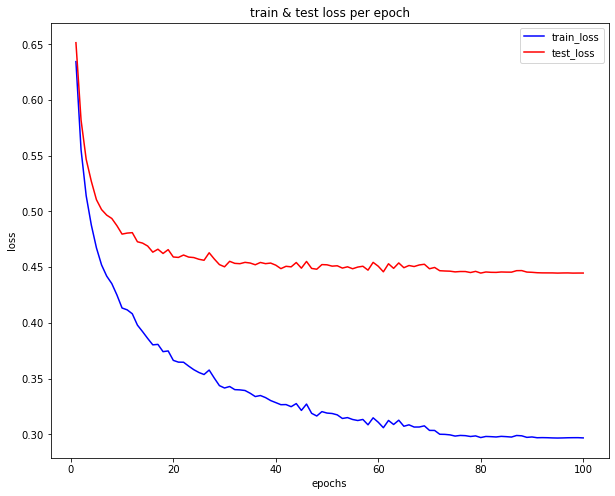

In [18]:
plt.figure(figsize=(10,8))

plt.plot(range(1, 101), train_loss, 'b-', label='train_loss')
plt.plot(range(1, 101), test_loss, 'r-', label='test_loss')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('train & test loss per epoch')
plt.legend()

plt.show()

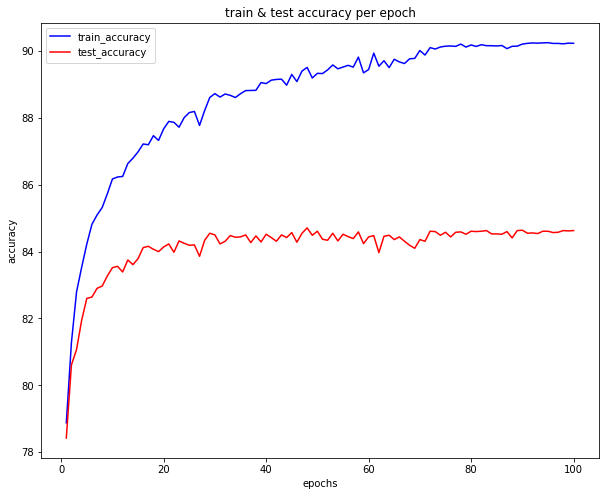

In [19]:
plt.figure(figsize=(10,8))

plt.plot(range(1, 101), train_accuracy, 'b-', label='train_accuracy')
plt.plot(range(1, 101), test_accuracy, 'r-', label='test_accuracy')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('train & test accuracy per epoch')
plt.legend()

plt.show()

In [20]:
print(f'Best epoch: {best_epoch}')
print(f'Train: accuracy: {best_train_accuracy:>0.1f}%, avg loss: {best_train_loss:>8f}')
print(f'Test: accuracy: {best_test_accuracy:>0.1f}%, avg loss: {best_test_loss:>8f}')

Best epoch: 48
Train: accuracy: 89.5%, avg loss: 0.316414
Test: accuracy: 84.7%, avg loss: 0.448151


## 5.4 Model metrics

In [21]:
print(f'Train:\n{classification_report(best_train_y, best_train_pred, target_names=target_names)}')
print(f'Test:\n{classification_report(best_test_y, best_test_pred, target_names=target_names)}')

Train:
              precision    recall  f1-score   support

    airplane       0.92      0.91      0.91      5000
  automobile       0.95      0.94      0.94      5000
        bird       0.90      0.83      0.86      5000
         cat       0.83      0.80      0.82      5000
        deer       0.84      0.89      0.86      5000
         dog       0.87      0.84      0.86      5000
        frog       0.89      0.93      0.91      5000
       horse       0.89      0.91      0.90      5000
        ship       0.94      0.95      0.95      5000
       truck       0.92      0.95      0.94      5000

    accuracy                           0.90     50000
   macro avg       0.90      0.90      0.89     50000
weighted avg       0.90      0.90      0.89     50000

Test:
              precision    recall  f1-score   support

    airplane       0.87      0.84      0.85      1000
  automobile       0.90      0.90      0.90      1000
        bird       0.86      0.79      0.83      1000
         ca

<AxesSubplot:>

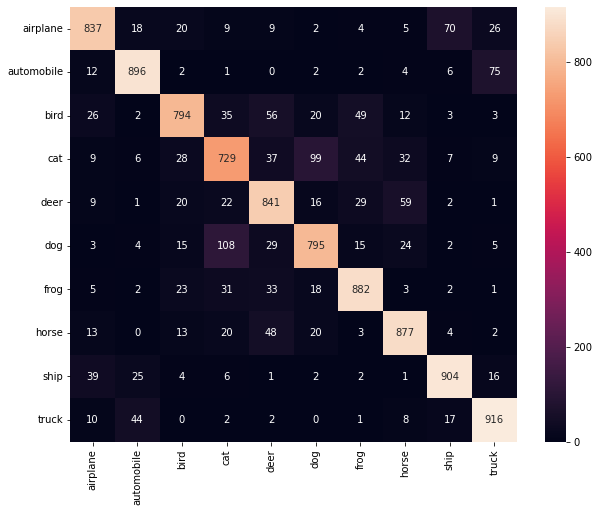

In [22]:
cm = confusion_matrix(best_test_y, best_test_pred)
sns.heatmap(cm, annot=True, fmt='', xticklabels=target_names, yticklabels=target_names, ax=plt.subplots(figsize=(10,8))[1])

## 5.5 Save model

In [23]:
torch.save(best_model_state_dict, '../saved-model/alexnet-weights.pth')